# Text Classification using Natural Language Processing (NLP)

## Loading required libraries:

In [1]:
# Libraries for data reading, cleaning, exploration and visualisation
import nltk         
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from matplotlib import pyplot as plt
%matplotlib inline

# Libraries for predictive modelling and evaluation
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time

## Read and Exploration of Data set

In [2]:
# Reading the raw data:    
pd.set_option('display.max_colwidth', 100)    # for adjusting the width of the column

rawData = pd.read_csv("sms_spam.csv")
rawData.columns = ['label_type', 'body_text']

rawData.head()

,label_type,body_text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW..."
4,spam,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH aw...


## Exploration of Data:

Thus we have 5559 rows and 2 columns. Out of 5559 rows, 747 are spam messages and 4812 are ham (good) messages. Please note, this is a clean data set and there are no missing values. 

In [3]:
# What is the shape of the dataset?

print("Input data has {} rows and {} columns".format(len(rawData), len(rawData.columns)))

Input data has 5559 rows and 2 columns


In [4]:
# How many spam/ham are there?

print("Out of {} rows, {} are spam, {} are ham".format(len(rawData),
                                                       len(rawData[rawData['label_type']=='spam']),
                                                       len(rawData[rawData['label_type']=='ham'])))

Out of 5559 rows, 747 are spam, 4812 are ham


In [5]:
# How much missing data is there?

print("Number of null in labels: {}".format(rawData['label_type'].isnull().sum()))
print("Number of null in texts: {}".format(rawData['body_text'].isnull().sum()))

Number of null in labels: 0
Number of null in texts: 0


## Featuring Engineering

Two type of feature creation have been tried out with a hypothesis:
1. Create feature for text message length
2. Create feature for % of text that is punctuation

Create feature for text message length
<br>
<br> Hypothesis: Spam messages are generally longer in size (text) than Non-spam messages
<br>
<br> From the graph below, it is clear than spam messages are longer in size than non-spam messages. This can be used as a feature in classification model. 

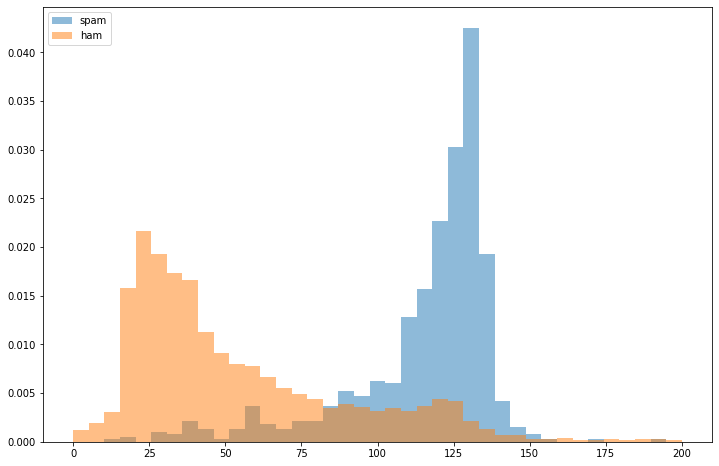

In [6]:
rawData['body_len'] = rawData['body_text'].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(0, 200, 40)
plt.figure(figsize=(12,8))
plt.hist(rawData[rawData['label_type']=='spam']['body_len'], bins, alpha=0.5, density=True, label='spam')
plt.hist(rawData[rawData['label_type']=='ham']['body_len'], bins, alpha=0.5, density=True, label='ham')
plt.legend(loc='upper left')
plt.show()

Create feature for % of text that is punctuation
<br>
<br> Hypothesis: Spam messages are generally have more punctuations than Non-spam messages
<br>
<br> From the graph below, we can see that the graph for spam messages and non spam messages are left skewed and thus, not evidence to support our hypothesis.  

In [7]:
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

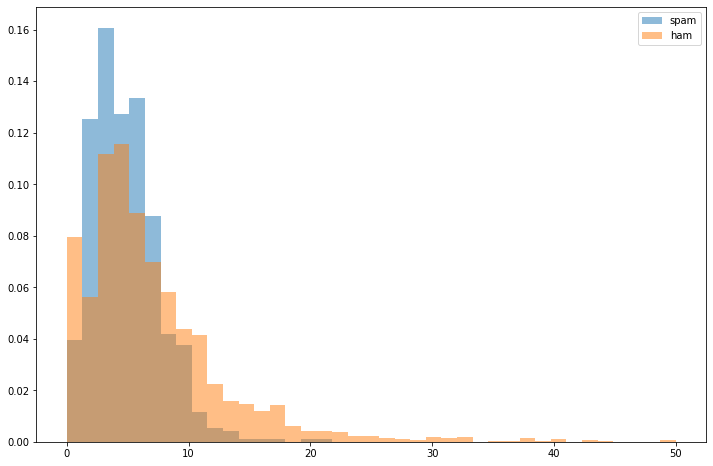

In [8]:
rawData['punct%'] = rawData['body_text'].apply(lambda x: count_punct(x))

bins = np.linspace(0, 50, 40)
plt.figure(figsize=(12,8))
plt.hist(rawData[rawData['label_type']=='spam']['punct%'], bins, alpha=0.5, density=True, label='spam')
plt.hist(rawData[rawData['label_type']=='ham']['punct%'], bins, alpha=0.5, density=True, label='ham')
plt.legend(loc='upper right')
plt.show()

## Test/Train Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(rawData[['body_text', 'body_len', 'punct%']], rawData['label_type'], 
                                                    test_size=0.25)

## Data Cleaning:

Removing punctuations and stopwords from the text body and tokenizing the words for model prediction. Also, using Lemmatize technique on clean text data for better accuracy.  

In [10]:
stopwords = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords]
    return text



## Vectorization

In [11]:
tfidf_vect = TfidfVectorizer(analyzer=clean_text)
tfidf_vect_fit = tfidf_vect.fit(X_train['body_text'])

tfidf_train = tfidf_vect_fit.transform(X_train['body_text'])
tfidf_test = tfidf_vect_fit.transform(X_test['body_text'])

X_train_vect = pd.concat([X_train[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_train.toarray())], axis=1)
X_test_vect = pd.concat([X_test[['body_len', 'punct%']].reset_index(drop=True), 
           pd.DataFrame(tfidf_test.toarray())], axis=1)

X_train_vect.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,7504,7505,7506,7507,7508,7509,7510,7511,7512,7513
0,47,6.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,146,7.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,83,3.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,125,2.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Building Model using GridSearch Algorithm

### Random Forest Algorithm

Used GridSearch method to find the best n_estimator and max_depth and then used the best result to find fit time and predict time for model comparison

In [12]:
def train_RF(n_est, max_depth, X_train, X_test):    
    rf = RandomForestClassifier(n_estimators=n_est, max_depth=max_depth, n_jobs=-1)
    rf_model = rf.fit(X_train, y_train)
    y_pred = rf_model.predict(X_test)
    precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')    
    return precision, recall, y_pred

In [13]:
rf_result = {"n_Est": [], "max_depth": [], "Precision": [], "Recall": [], "Accuracy": [] }

for n_est in [10, 50, 100,150,300,500]:
    for max_depth in [10, 20, 30, None]:
        precision, recall, y_pred = train_RF(n_est, max_depth, X_train_vect, X_test_vect)
        rf_result["n_Est"].append(n_est)
        rf_result["max_depth"].append(max_depth)
        rf_result["Precision"].append(round(precision, 3))
        rf_result["Recall"].append(round(recall, 3))
        rf_result["Accuracy"].append(round((y_pred==y_test).sum() / len(y_pred), 3))

rf_result = pd.DataFrame(rf_result)
rf_result.sort_values("Accuracy", ascending=False).head()

,n_Est,max_depth,Precision,Recall,Accuracy
19,300,NaN,1.0,0.842,0.978
7,50,NaN,1.0,0.837,0.978
11,100,NaN,1.0,0.842,0.978
23,500,NaN,1.0,0.832,0.977
15,150,NaN,1.0,0.826,0.976


### Gradient-Boosting Algorithm with GridSearch

Used GridSearch method to find the best n_estimator, max_depth and learning rate and then used the best result to find fit time and predict time for model comparison

In [20]:
def train_GB(est, max_depth, lr, X_train, X_test):
    gb = GradientBoostingClassifier(n_estimators=est, max_depth=max_depth, learning_rate=lr)
    gb_model = gb.fit(X_train, y_train)
    y_pred = gb_model.predict(X_test)
    precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
    return precision, recall, y_pred

In [19]:
gb_result = {"n_Est": [], "max_depth": [], "LR": [], "Precision": [], "Recall": [], "Accuracy": [] }

for n_est in [50, 100, 150, 300, 500]:
    for max_depth in [3, 7, 11, 15]:
        for lr in [0.01, 0.1, 1]:
            precision, recall, y_pred = train_GB(n_est, max_depth, lr, X_train_vect, X_test_vect)
            gb_result["n_Est"].append(n_est)
            gb_result["max_depth"].append(max_depth)
            gb_result["LR"].append(lr)
            gb_result["Precision"].append(round(precision, 3))
            gb_result["Recall"].append(round(recall, 3))
            gb_result["Accuracy"].append(round((y_pred==y_test).sum() / len(y_pred), 3))
            
gb_result = pd.DataFrame(gb_result)
gb_result.sort_values("Accuracy", ascending=False).head()

,n_Est,max_depth,LR,Precision,Recall,Accuracy
58,500,15,0.1,0.989,0.905,0.986
46,300,15,0.1,0.983,0.900,0.984
55,500,11,0.1,0.988,0.895,0.984
43,300,11,0.1,0.977,0.900,0.983
49,500,3,0.1,0.988,0.879,0.982


## Model Comparison

In [14]:
rf = RandomForestClassifier(n_estimators=150, max_depth=None, n_jobs=-1)

start = time.time()
rf_model = rf.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = rf_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 3.037 / Predict time: 0.188 ---- Precision: 1.0 / Recall: 0.847 / Accuracy: 0.979


In [22]:
gb = GradientBoostingClassifier(n_estimators=500, max_depth=15, learning_rate=0.1)

start = time.time()
gb_model = gb.fit(X_train_vect, y_train)
end = time.time()
fit_time = (end - start)

start = time.time()
y_pred = gb_model.predict(X_test_vect)
end = time.time()
pred_time = (end - start)

precision, recall, fscore, train_support = score(y_test, y_pred, pos_label='spam', average='binary')
print('Fit time: {} / Predict time: {} ---- Precision: {} / Recall: {} / Accuracy: {}'.format(
    round(fit_time, 3), round(pred_time, 3), round(precision, 3), round(recall, 3), round((y_pred==y_test).sum()/len(y_pred), 3)))

Fit time: 680.613 / Predict time: 0.181 ---- Precision: 0.989 / Recall: 0.905 / Accuracy: 0.986
